## 1.1 Model Hamiltonian

The model Hamiltonian is

$$
    H = \Omega (\sigma_x^{(1)} + \sigma_x^{(2)})
        e^{i [ \eta(a e^{-i\nu t} + a^{\dagger} e^{i\nu t}) - (\nu + \Delta)t]}
        + \textrm{h.c.}
$$

where $\Omega, \Delta$ are model parameters, $\nu$ is the motional frequency of the ion chain, and $\eta$ is the Lamb-Dicke parameter. 

The target Hamiltonian acts on a wavefunction as $U = e^{-iHt}$. 

## 1.2 Quantum channels

We can thus define an effective channel generated by a target Hamiltonian, written in a Kraus representation
$$
    \Psi_H[\rho] = e^{-iHt} \rho e^{iHt}
$$
or instead as process matrix
$$
    K[H] \vec{\rho} = e^{-iHt} \otimes e^{-iHt} \vec{\rho} 
$$
(we're using a row-stack convention, where $\vec{\rho} = \sum {\rho_{i,j}} |i\rangle |j\rangle$) or finally using double bra-ket notation
$$
    = K[H] | \rho \rangle \rangle. 
$$

Thus, for this 1-qubit model, we define probabiliy for 0 (dark-state):
$$
    p_0(t) \equiv P(0|\theta_1, \theta_2, t) = \langle \langle E_0| K[H(t)] | \rho \rangle \rangle
$$
and 1 (light-state):
$$
    p_1(t) \equiv P(1|\theta_1, \theta_2, t) = \langle \langle E_1 |K[H(t)] | \rho \rangle \rangle
$$
where $E_\mu$ is a measurement effect corresponding to 0 and 1. In the computational basis, $E_0 = (1, 0, 0, 0)$ and $E_1 = (0, 0, 0, 1)$

## 1.3 Probabilities

Okay, so everything before was overkill. Since we're assuming that we prepare the 0 state perfectly, we can just use the simpiler 
$$
    p_0(t) = | \langle 0 | e^{-iUt} | 0 \rangle |^2
$$
and 
$$
    p_1(t) = | \langle 1 | e^{-iUt} | 0 \rangle |^2
$$

## 1.4 multinomial distribution

We'll use a multinomial distribution for the outcomes (okay it's a binomial here, but for 2+ qubits it'll be multinomial)

$$
f(x_0, x_1 | p_0, p_1, t) = {(x_0 + x_1)! \choose x_0! x_1!} (p_0(t))^{x_0} (p_1(t))^{x_1} 
$$

## 1.5 Likelihood 

The likelihood is then 

$$
L(\theta_1, \theta_2 | x_0, x_1) = \prod_t f(x_0(t), x_1(t) | p_0, p_1, t) = 
$$$$
     \prod_t {(x_0(t) + x_1(t))! \choose (x_0(t))! (x_1(t))!}   (p_0(t))^{x_0(t)} (p_1(t))^{x_1(t)} 
$$


## 1.2 Log-Likelihood 

The log-likelihood is 
$$
    O(\vec{x}_0, \vec{x}_1) = \sum_t \log {(x_0(t) + x_1(t))! \choose (x_0(t))! (x_1(t))!} + \sum_t x_0(t) \log p_0(t) + \sum_t x_1(t) \log p_1(t)
$$ 

In [2]:
using IonSim
using QuantumOptics: timeevolution, stochastic
using StochasticDiffEq
using ScikitLearn
using Random
using Optim
using Distributions
using LinearAlgebra
import PyPlot
const plt = PyPlot;

## Define our trap

In [4]:
# calculate η
function calculate_η()
    ions = [Ca40(["S-1/2", "D-1/2"]), Ca40(["S-1/2", "D-1/2"])]
    chain = LinearChain(ions=ions, com_frequencies=(x=3e6,y=3e6,z=1e6), vibrational_modes=(;z=[1]))
    lasers = [
        Laser(k = (x̂ + ẑ)/√2, ϵ = (x̂ - ẑ)/√2),
        Laser(k = (x̂ + ẑ)/√2, ϵ = (x̂ - ẑ)/√2)
    ]
    trap = Trap(configuration=chain, B=4e-4, Bhat=ẑ, δB=0, lasers=lasers)
    axial_mode = trap.configuration.vibrational_modes.z[1]
    axial_mode.N = 10
    return axial_mode, abs(get_η(axial_mode, lasers[1], ions[1]))
end

axial_mode, η = calculate_η();

In [3]:
struct HamiltonianParameters
    detuning_khz::Float64
    pi_time_μs::Float64
    ac_stark_shift_hz::Float64
end

In [7]:
function simulate_trap(tspan, θ::HamiltonianParameters)
    # defining trap parameters
    ca_ions = [Ca40(["S-1/2", "D-1/2"]), Ca40(["S-1/2", "D-1/2"])]
    chain = LinearChain(
        ions=ca_ions,
        com_frequencies=(x=3e6,y=3e6,z=1e6), 
        vibrational_modes=(;z=[1]),
    )
    lasers = [
        Laser(k = (x̂ + ẑ)/√2, ϵ = (x̂ - ẑ)/√2),
        Laser(k = (x̂ + ẑ)/√2, ϵ = (x̂ - ẑ)/√2)
    ]
    trap = Trap(configuration=chain, B=4e-4, Bhat=ẑ, δB=0, lasers=lasers)

    mode = trap.configuration.vibrational_modes.z[1]
    mode.N = 10

    Efield_from_pi_time!(θ.pi_time_μs * 1e-6, trap, 1, 1, ("S-1/2", "D-1/2"));
    Efield_from_pi_time!(θ.pi_time_μs * 1e-6, trap, 2, 1, ("S-1/2", "D-1/2"));
    
    Δ = θ.detuning_khz * 1e3
    d = θ.ac_stark_shift_hz  # AC Stark shift compensation
    f = transition_frequency(trap, 1, ("S-1/2", "D-1/2"))
    
    detuned_lasers = [copy(lasers[1]), copy(lasers[2])]
    detuned_lasers[1].Δ = f + mode.ν + Δ - d
    detuned_lasers[2].Δ = f - mode.ν - Δ + d
    
    trap.lasers = detuned_lasers    

    h = hamiltonian(trap, timescale=1e-6, rwa_cutoff=1e5)
    @time tout, sol = timeevolution.schroedinger_dynamic(
        tspan, ca_ions[1]["S-1/2"] ⊗ ca_ions[2]["S-1/2"] ⊗ mode[0],
        h)
    
    SS = real.(expect(ionprojector(trap, "S-1/2", "S-1/2"), sol))
    DD = real.(expect(ionprojector(trap, "D-1/2", "D-1/2"), sol))
    SD = real.(expect(ionprojector(trap, "S-1/2", "D-1/2"), sol))
    DS = real.(expect(ionprojector(trap, "D-1/2", "S-1/2"), sol))
    
    return tout, SS, DD, SD, DS
end;

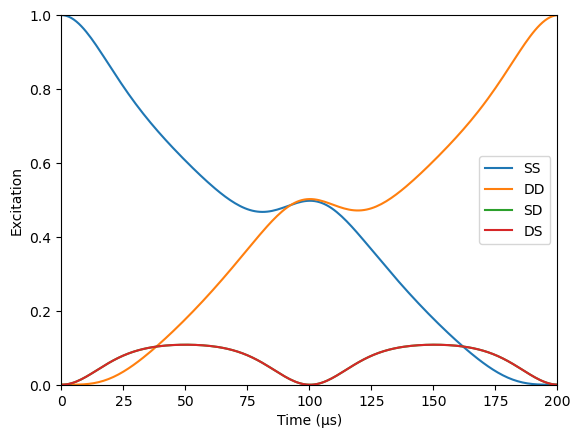

  8.124546 seconds (13.25 M allocations: 654.184 MiB, 2.96% gc time)


In [8]:
ideal_detuning_khz = 10
ideal_pi_time_μs = 1e6 * η / (ideal_detuning_khz * 1e3)
ideal_ac_stark_shift_hz = 35

ideal_θ = HamiltonianParameters(
    ideal_detuning_khz,
    ideal_pi_time_μs,
    ideal_ac_stark_shift_hz,
)

tspan = 0:1:200
tout, SS, DD, SD, DS = simulate_trap(tspan, ideal_θ)

plt.plot(tout, SS, label="SS")
plt.plot(tout, DD, label="DD")
plt.plot(tout, SD, label="SD")
plt.plot(tout, DS, label="DS")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)")
plt.legend();

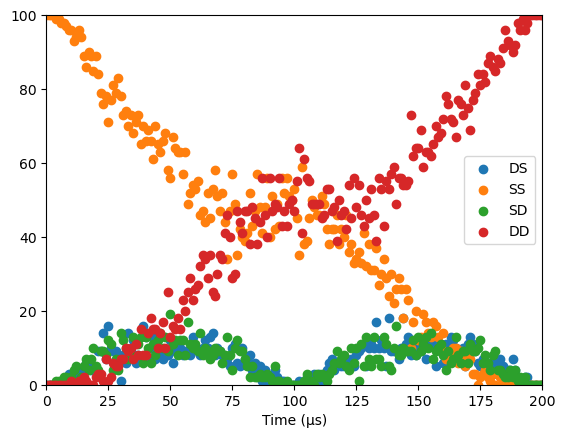

In [9]:
# function to simulate taking real data
function simulate_experiment(N, SS, DD, SD, DS)
    samples = []
    for i in eachindex(SS)
        sample = Dict("SS" => 0, "DD" => 0, "SD" => 0, "DS" => 0)
        for _ in 1:N
            number = rand(Float64)
            if number <= SS[i]
                sample["SS"] += 1
            elseif number <= SS[i] + DD[i]
                sample["DD"] += 1
            elseif number <= SS[i] + DD[i] + SD[i]
                sample["SD"] += 1
            else
                sample["DS"] += 1
            end
        end
        push!(samples, sample)
    end
    return samples
end

N = 100
samples = simulate_experiment(N, SS, DD, SD, DS)
for state in keys(samples[1])
    plt.scatter(tout, getindex.(samples, state), label=state)
end
plt.xlim(tout[1], tout[end])
plt.ylim(0, N)
plt.xlabel("Time (μs)")
plt.legend();

## Define our model, likelihood, and objective using IonSim.jl

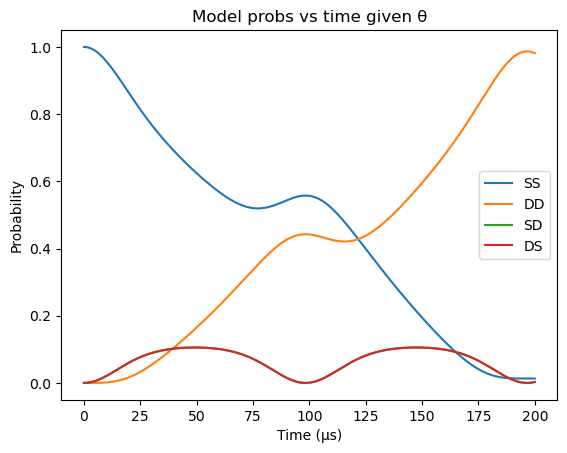

  0.007725 seconds (176.10 k allocations: 4.804 MiB)


In [10]:
# model the the experimental outcomes with slight miscalibration
pi_time_μs = ideal_pi_time_μs * 1.02
Δ_khz = ideal_detuning_khz * 1.02

θ = HamiltonianParameters(
    Δ_khz,
    pi_time_μs,
    ideal_ac_stark_shift_hz,
)

tspan = 0:1:200
tout, SS, DD, SD, DS = simulate_trap(tspan, θ)

plt.plot(tout, SS, label="SS")
plt.plot(tout, DD, label="DD")
plt.plot(tout, SD, label="SD")
plt.plot(tout, DS, label="DS")

plt.title("Model probs vs time given θ")
plt.xlabel("Time (μs)")
plt.ylabel("Probability")
plt.legend();

In [11]:
function log_likelihood(samples, num_experiments, times, θ::HamiltonianParameters)
    out = 0    
    tout, p_SS, p_DD, p_SD, p_DS = simulate_trap(times, θ)
    for i in eachindex(times)
        probabilities = [p_SS[i], p_DD[i], p_SD[i], p_DS[i]] ./ (p_SS[i] + p_DD[i] + p_SD[i] + p_DS[i])
        dist = Multinomial(num_experiments, probabilities)
        term = logpdf(dist, [samples[i]["SS"], samples[i]["DD"], samples[i]["SD"], samples[i]["DS"]])
        if term != NaN
            out += term
        end
    end    
    return out
end

log_likelihood (generic function with 1 method)

## Make some batches of data and optimize

In [12]:
N = 100
samples = simulate_experiment(N, SS, DD, SD, DS)

function objective(θ::Vector)
    θ = HamiltonianParameters(θ[1], θ[2], θ[3])
    return -log_likelihood(samples, N, tout, θ)
end

objective (generic function with 1 method)

In [13]:
log_likelihood(samples, 100, tout, ideal_θ)

  0.017978 seconds (187.20 k allocations: 5.225 MiB)


-1420.530905386309

In [15]:
initial_guess = [ideal_θ.detuning_khz, ideal_θ.pi_time_μs, ideal_θ.ac_stark_shift_hz]
res = optimize(objective, initial_guess)

  0.007422 seconds (181.14 k allocations: 4.934 MiB)
  0.008045 seconds (176.10 k allocations: 4.802 MiB)
  0.005324 seconds (118.98 k allocations: 3.308 MiB)
  0.007961 seconds (181.14 k allocations: 4.934 MiB)
  0.017044 seconds (377.70 k allocations: 10.075 MiB)
  0.006566 seconds (137.46 k allocations: 3.791 MiB)
  0.009130 seconds (157.62 k allocations: 4.318 MiB)
  0.011549 seconds (218.10 k allocations: 5.900 MiB)
  0.052093 seconds (150.90 k allocations: 4.143 MiB, 85.50% gc time)
  0.010209 seconds (189.54 k allocations: 5.153 MiB)
  0.007917 seconds (160.98 k allocations: 4.406 MiB)
  0.007956 seconds (181.14 k allocations: 4.934 MiB)
  0.012767 seconds (159.30 k allocations: 4.362 MiB)
  0.010792 seconds (160.98 k allocations: 4.406 MiB)
  0.009647 seconds (186.18 k allocations: 5.066 MiB)
  0.007395 seconds (177.78 k allocations: 4.846 MiB)
  0.007094 seconds (169.38 k allocations: 4.626 MiB)
  0.007823 seconds (174.42 k allocations: 4.758 MiB)
  0.008217 seconds (172.74 k 

  0.008000 seconds (176.10 k allocations: 4.802 MiB)
  0.008603 seconds (176.10 k allocations: 4.802 MiB)
  0.008641 seconds (176.10 k allocations: 4.802 MiB)
  0.008704 seconds (176.10 k allocations: 4.802 MiB)
  0.008804 seconds (176.10 k allocations: 4.802 MiB)
  0.008642 seconds (176.10 k allocations: 4.802 MiB)
  0.008621 seconds (176.10 k allocations: 4.802 MiB)
  0.010257 seconds (176.10 k allocations: 4.802 MiB)
  0.010217 seconds (176.10 k allocations: 4.802 MiB)
  0.008421 seconds (176.10 k allocations: 4.802 MiB)
  0.008437 seconds (176.10 k allocations: 4.802 MiB)
  0.008579 seconds (176.10 k allocations: 4.802 MiB)
  0.008662 seconds (176.10 k allocations: 4.802 MiB)
  0.008557 seconds (176.10 k allocations: 4.802 MiB)
  0.008461 seconds (176.10 k allocations: 4.802 MiB)
  0.039240 seconds (176.10 k allocations: 4.802 MiB, 75.13% gc time)
  0.008991 seconds (176.10 k allocations: 4.802 MiB)
  0.007960 seconds (176.10 k allocations: 4.802 MiB)
  0.007763 seconds (176.10 k a

 * Status: success

 * Candidate solution
    Final objective value:     1.293159e+03

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   3  (vs limit Inf)
    Iterations:    88
    f(x) calls:    182


In [16]:
Optim.minimizer(res)

3-element Array{Float64,1}:
 10.196791171283026
  4.9419409858618195
 43.759980157920786

In [17]:
θ

HamiltonianParameters(10.2, 4.942159390600017, 35.0)